In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [ ]:
df = pd.read_csv("stock.csv")
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-08,453.399994,455.000000,441.549988,442.725006,425.550629,4958862.0
1,2015-06-09,441.774994,445.325012,438.674988,441.850006,424.709564,4184606.0
2,2015-06-10,443.000000,454.950012,442.500000,452.899994,435.330933,6176034.0
3,2015-06-11,453.000000,454.750000,436.825012,438.575012,421.561676,6709574.0
4,2015-06-12,439.500000,446.350006,439.125000,444.924988,427.665283,9849112.0


In [ ]:
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume
1224,2020-06-01,1480.0,1538.349976,1475.949951,1520.349976,1520.349976,18434012.0
1225,2020-06-02,1526.0,1540.000000,1520.800049,1535.699951,1535.699951,10224049.0
1226,2020-06-03,1545.0,1560.000000,1533.349976,1541.650024,1541.650024,11713461.0
1227,2020-06-04,1544.0,1589.500000,1541.000000,1579.800049,1579.800049,15784379.0
1228,2020-06-05,1595.0,1618.000000,1573.699951,1581.699951,1581.699951,15246965.0


In [ ]:
df_close = df['Close']

In [ ]:
df_close.shape

(1228,)

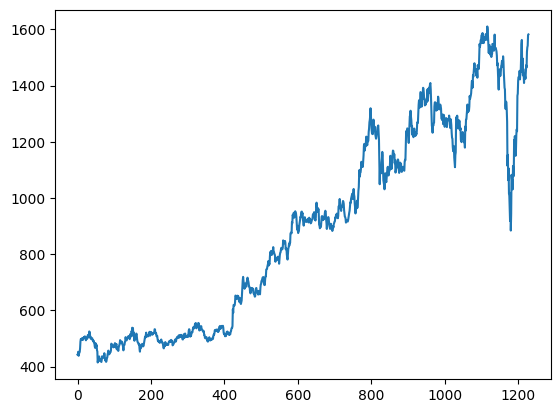

In [ ]:
plt.plot(df_close)


In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [ ]:
df_close.shape


(1228, 1)

In [ ]:
df_close


array([[0.02338571],
       [0.0226536 ],
       [0.0318991 ],
       ...,
       [0.94285362],
       [0.97477365],
       [0.97636329]])

In [ ]:
training_size = int(len(df_close) * 0.75)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [ ]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 25, batch_size = 64, verbose = 1)

Epoch 1/25
13/13 [==============================] - 16s 546ms/step - loss: 0.0490 - val_loss: 0.0336
Epoch 2/25
13/13 [==============================] - 5s 393ms/step - loss: 0.0081 - val_loss: 0.0102
Epoch 3/25
13/13 [==============================] - 6s 448ms/step - loss: 0.0026 - val_loss: 0.0095
Epoch 4/25
13/13 [==============================] - 7s 502ms/step - loss: 0.0014 - val_loss: 0.0099
Epoch 5/25
13/13 [==============================] - 7s 492ms/step - loss: 0.0011 - val_loss: 0.0094
Epoch 6/25
13/13 [==============================] - 5s 386ms/step - loss: 0.0010 - val_loss: 0.0088
Epoch 7/25
13/13 [==============================] - 5s 385ms/step - loss: 9.6886e-04 - val_loss: 0.0085
Epoch 8/25
13/13 [==============================] - 6s 480ms/step - loss: 9.2019e-04 - val_loss: 0.0081
Epoch 9/25
13/13 [==============================] - 5s 387ms/step - loss: 9.4305e-04 - val_loss: 0.0080
Epoch 10/25
13/13 [==============================] - 6s 496ms/step - loss: 8.9852e-04 -

In [ ]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
math.sqrt(mean_squared_error(y_train, train_predict))

807.5734299390177

In [ ]:
math.sqrt(mean_squared_error(y_test, test_predict))

1325.6567358381603

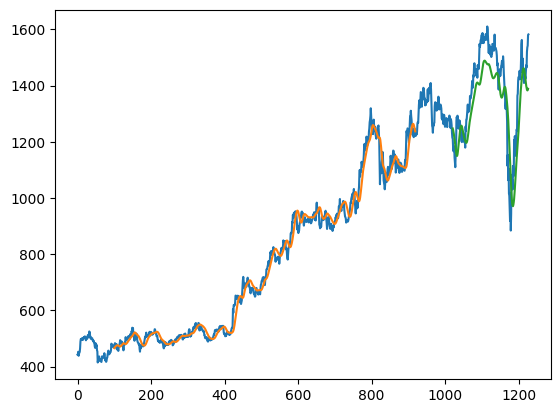

In [ ]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data), x_test.shape

(307, (206, 100, 1))

In [ ]:
x_input = test_data[207:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [ ]:
df3 = df_close.tolist()
df3.extend(lst_output)

In [ ]:
len(df_close)

1228